# Import Libraries

In [75]:
import numpy             as np
import pandas            as pd
import seaborn           as sb
import plotly.express    as px
import matplotlib.pyplot as plt
import math
import random
import sklearn.metrics

from numpy.linalg            import norm
from sklearn                 import preprocessing
from numpy.linalg            import eig
from numpy.linalg            import inv
from tqdm                    import tqdm
from scikitplot.metrics      import plot_confusion_matrix

# Function

## - General Function

In [1]:
#Return Label converted from String to Int
def convert_Label(y):
    labelEncoder = preprocessing.LabelEncoder()#Initialize LabelEncoder Object

    labelEncoder.fit(y)
    y_n =labelEncoder.transform(y)

    return y_n

#Return standardized data
def standard(x):
    return(x-x.mean())/x.std()

## - Function for PCA

In [77]:
def eigen_calc(A):
    #find eigenvalue & eigenvectors
    eigenValues, eigenVectors = eig(A)
    #sort eigenvector 
    i =  np.argsort(eigenValues)[::-1]
    sorted_eigenvalue   =  eigenValues[i]
    sorted_eigenvectors =  eigenVectors[:,i]

    return sorted_eigenvalue, sorted_eigenvectors

def pca(dataset, n_comp):
    
    #1 Calculate covariance matrix
    cov_mat = np.cov(dataset, rowvar = False )
    print("Forma della matrice di covarianza", cov_mat.shape)
    #2 Find eigenvalue & eigenvectors
    eig_val, eig_vec = eigen_calc(cov_mat)
    eig_vec = eig_vec/norm(eig_vec)
    #3 Choose number of component 
    expl_var = np.cumsum(eig_val)/np.sum(eig_val)
    plt.plot(expl_var)
    #4 Select 'n_comp' principal component 
    eig_vec_sub = eig_vec[:, 0:n_comp]
    #5 Project eigenvector on dataset
    pca_data = pd.DataFrame(dataset.dot(eig_vec_sub))     

    return pca_data

## - Function for K-Means

In [79]:
#return euclidean distance between two point p1 & p2
def get_dist_euclidea(p1, p2):
    distance = 0
    for i in range(len(p1)):
        distance += ((p2[i] - p1[i])**2)
    
    return math.sqrt(distance)
    
#Return array with k centroids
def init_centroids(data, cluster, k):
    
    #Init k cluster     
    for i in range(k):
        cluster[i] = []

    #Build np array for centroids
    centroids = np.zeros((k, len(data.columns)))

    for i in range(len(centroids)):
        rand_idx = random.randint(0, len(data)-1)#Choose random index
        #Init Centroid for 'lb_centroid[rand_idx]'
        centroids[i] = data.iloc[rand_idx, :]

        
    return centroids, cluster

#Return Dictionary, each index 
def assignment(data, cluster, centroid):

    for i in data.index:
        centr = 0#will contain the centroid with min distance
        d_min = 100

        #Calculate distance between point & each centroid
        for j in range(len(centroid)):
    
            distance = get_dist_euclidea(data.iloc[i,:], centroid[j])
            if distance < d_min:
                d_min = distance
                centr = j
                
        cluster[centr].append(i)

    return cluster

#re-estimate centroid
def re_estimate_centroids(cluster, centroid, data, k):
    
    c_old = centroid
    for i in range(k):

        #Compute mean for each cluster
        df = pd.DataFrame(columns=data.columns)

        for i in range(len(cluster)):
            df.loc[i,:] = data.iloc[i,:]

        centroid[i] = np.mean(df, axis=0)
   
    if np.array_equiv(c_old, centroid):
        return None

    return centroid

def k_means(data, k):
 
    #Initialize Cluster & random centroids
    clusters  = {}
    centroids, clusters = init_centroids(data, clusters, k)
    #Note that centroids & clusters are connected by the index
    while True:
        #1. Assign sample at Cluster with fixed centroid
        clusters = assignment(data, clusters, centroids)
        
        #2. Re estimate centroids with fixed point
        centroids = re_estimate_centroids(clusters, centroids, data, k)
        if centroids == None:
            break

    return clusters


# Pipeline

## 1. Data Collection

### - 1.1 Load Dataset

In [80]:
#Import dataset
train = pd.read_csv('../Data/train.csv')

### - 1.2 Splitting & Standardization of Dataset

In [81]:
#Extract Label from Dataset
data = train.loc[:, train.columns != 'Activity']
data = data.loc[:, data.columns != 'subject']

In [82]:
data = standard(data)

data.describe()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
count,7.352000e+03,7.352000e+03,7.352000e+03,7.352000e+03,7.352000e+03,7.352000e+03,7.352000e+03,7.352000e+03,7.352000e+03,7.352000e+03,...,7.352000e+03,7.352000e+03,7.352000e+03,7.352000e+03,7.352000e+03,7.352000e+03,7.352000e+03,7.352000e+03,7.352000e+03,7.352000e+03
mean,8.381882e-15,1.360597e-16,-5.324570e-15,-1.979555e-15,-2.678262e-15,-3.624866e-15,-4.231276e-15,2.603829e-15,2.975676e-15,3.792759e-16,...,-1.503754e-15,1.120979e-15,-7.024781e-15,4.871572e-17,-4.654873e-18,-2.598310e-17,4.777946e-17,-2.125582e-15,3.493004e-16,8.287410e-17
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.813925e+01,-2.406988e+01,-1.572978e+01,-8.792764e-01,-9.727257e-01,-9.440145e-01,-8.712843e-01,-9.735585e-01,-9.510475e-01,-9.758504e-01,...,-4.483353e+00,-2.144314e+00,-1.217458e+00,-2.925484e+00,-2.235494e+00,-1.658262e+00,-2.079646e+00,-9.973544e-01,-3.558535e+00,-3.380187e+00
25%,-1.638582e-01,-1.756307e-01,-2.092656e-01,-8.631281e-01,-9.294663e-01,-8.968028e-01,-8.561706e-01,-9.286192e-01,-9.033588e-01,-8.587230e-01,...,-5.935840e-01,-7.339086e-01,-7.161599e-01,-3.866278e-01,-6.507494e-01,-8.071617e-01,-7.748532e-01,-6.301555e-01,-2.570847e-01,-3.113314e-01
50%,3.850240e-02,1.167061e-02,8.206385e-03,-7.593756e-01,-6.783303e-01,-6.081180e-01,-7.550522e-01,-6.799602e-01,-6.060835e-01,-7.584903e-01,...,3.468748e-02,-1.142519e-01,-2.808939e-01,2.450848e-03,1.507215e-02,1.477437e-05,1.174332e-02,-4.295960e-01,4.150803e-01,2.138701e-01
75%,1.988718e-01,1.693790e-01,2.003602e-01,8.081076e-01,9.483971e-01,8.176492e-01,7.966371e-01,9.470407e-01,8.221719e-01,8.290848e-01,...,6.526152e-01,5.608230e-01,3.947416e-01,4.221715e-01,6.483850e-01,8.177859e-01,7.643676e-01,-3.816311e-02,6.378898e-01,5.881780e-01
max,1.032591e+01,2.493708e+01,1.958396e+01,3.577703e+00,2.839333e+00,3.832827e+00,3.844889e+00,3.075619e+00,3.878450e+00,2.696930e+00,...,3.272618e+00,4.038951e+00,5.143761e+00,2.943456e+00,2.225741e+00,1.627440e+00,2.096467e+00,2.910370e+00,1.410395e+00,3.785133e+00


## 2. Feature Extraction

### - 2.1. PCA - Principal Component Analysis

Forma della matrice di covarianza (561, 561)
Shape of Train set after  PCA (7352, 120)


c:\Users\USER\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


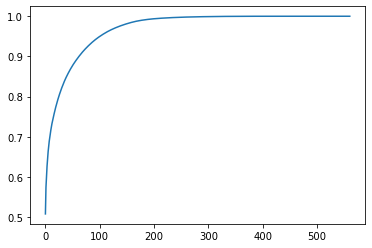

In [83]:
#Apply PCA 
n_components = 120
data = pca(data.to_numpy(), n_components)

print("Shape of Train set after  PCA", data.shape)

## 3. Clustering

### 3.1 K Means

c:\Users\USER\anaconda3\lib\site-packages\pandas\core\series.py:872: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(self._values, dtype)
C:\Users\USER\AppData\Local\Temp\ipykernel_14544\400257360.py:7: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.sqrt(distance)
c:\Users\USER\anaconda3\lib\site-packages\matplotlib\collections.py:200: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


<AxesSubplot:xlabel='0', ylabel='1'>

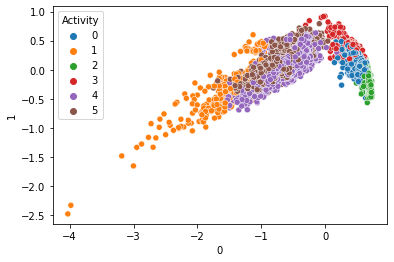

In [84]:
#Apply K Means
cluster = k_means(data, 6)

data['Activity'] = 0

#Assign label at dataset
for lb in cluster:
    for i in cluster[lb]:
        data.loc[i, 'Activity'] = lb

palette ={0: "C0", 1: "C1",2: "C2",3: "C3", 4: "C4", 5: "C5"}


sb.scatterplot(data = data, x=0, y=1, hue=data.Activity, palette=palette)

## Explore Data for find difference between original label & clustered label

Note that there is no correspondence between the labels found with k means and the initial labels

In [92]:
#Cluster
#Frequency of each Activity
print("Frequency of each Activity")
print(train['Activity'].groupby(train['Activity']).count())


print("\nFrequency of each Activity")
print(data['Activity'].groupby(data['Activity']).count())

Frequency of each Activity
Activity
LAYING                1407
SITTING               1286
STANDING              1374
WALKING               1226
WALKING_DOWNSTAIRS     986
WALKING_UPSTAIRS      1073
Name: Activity, dtype: int64

Frequency of each Activity
Activity
0    2023
1     277
2    1620
3     414
4    1504
5    1514
Name: Activity, dtype: int64


In [93]:
#Count Activity for each subject
px.histogram(data_frame=train, x="subject", color="Activity", barmode='group')

In [89]:
#Count Activity for each subject
data['subject'] = train.subject
px.histogram(data_frame=data, x="subject", color="Activity", barmode='group')